In [2]:
import os
from os import path as osp
import numpy as np
import pickle
import json
import torch

from mmengine.config import Config, DictAction
from mmengine.registry import init_default_scope
from mmengine.utils import ProgressBar, mkdir_or_exist

from mmdet3d.registry import DATASETS, VISUALIZERS
from mmdet3d.utils import replace_ceph_backend

from mmdet3d.apis import init_model, inference_detector
from sensus import configs

from matplotlib import pyplot as plt
from mmdet3d.structures.bbox_3d.cam_box3d import CameraInstance3DBoxes
from mmdet3d.structures.bbox_3d.lidar_box3d import LiDARInstance3DBoxes
import cv2
import copy
from mmdet3d.visualization.vis_utils import proj_camera_bbox3d_to_img, proj_lidar_bbox3d_to_img

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [3]:
os.chdir('../')

In [4]:
def build_data_cfg(config_path, aug, cfg_options):
    """Build data config for loading visualization data."""

    cfg = Config.fromfile(config_path)
    if cfg_options is not None:
        cfg.merge_from_dict(cfg_options)

    # extract inner dataset of `RepeatDataset` as
    # `cfg.train_dataloader.dataset` so we don't
    # need to worry about it later
    if cfg.train_dataloader.dataset['type'] == 'RepeatDataset':
        cfg.train_dataloader.dataset = cfg.train_dataloader.dataset.dataset
    # use only first dataset for `ConcatDataset`
    if cfg.train_dataloader.dataset['type'] == 'ConcatDataset':
        cfg.train_dataloader.dataset = cfg.train_dataloader.dataset.datasets[0]
    if cfg.train_dataloader.dataset['type'] == 'CBGSDataset':
        cfg.train_dataloader.dataset = cfg.train_dataloader.dataset.dataset

    train_data_cfg = cfg.train_dataloader.dataset

    if aug:
        show_pipeline = cfg.train_pipeline
    else:
        show_pipeline = cfg.test_pipeline
        for i in range(len(cfg.train_pipeline)):
            if cfg.train_pipeline[i]['type'] == 'LoadAnnotations3D':
                show_pipeline.insert(i, cfg.train_pipeline[i])
            # Collect data as well as labels
            if cfg.train_pipeline[i]['type'] == 'Pack3DDetInputs':
                if show_pipeline[-1]['type'] == 'Pack3DDetInputs':
                    show_pipeline[-1] = cfg.train_pipeline[i]
                else:
                    show_pipeline.append(cfg.train_pipeline[i])

    train_data_cfg['pipeline'] = show_pipeline

    return cfg

In [5]:
config_path = osp.join(configs.__path__[0], '_base_', 'datasets',
    'dair-infrastructure-3d-3class.py')
preds_path = osp.join(configs.__path__[0], '..', 'output',
    'pointpillars_hv_secfpn_8xb6-160e_dair-vehicle-3d-3class-pred_instances_3d.pkl')

In [7]:
cfg = build_data_cfg(config_path, False, None)
init_default_scope(cfg.get('default_scope', 'mmdet3d'))
vis_task = 'mono_det'

# Load pkl

In [9]:
infos_path = 'data/DAIR-V2X/cooperative-vehicle-infrastructure-kittiformat/infrastructure-side/dair_infos_train.pkl'
dair_train_infos = pickle.load(open(infos_path, 'rb'))

In [26]:
dair_train_infos['data_list'][230]['instances']

[{'bbox': [747.706909, 165.51683, 784.597168, 196.742004],
  'bbox_label': 2,
  'bbox_3d': [-10.906935393302195,
   -17.877021436496005,
   118.54484330972555,
   1.737226,
   1.546024,
   4.185409,
   0.03193708105641283],
  'bbox_label_3d': 2,
  'depth': 118.54484558105469,
  'center_2d': [767.5528564453125, 175.45021057128906],
  'num_lidar_pts': 0,
  'difficulty': 1,
  'truncated': 0.0,
  'occluded': 0,
  'alpha': 4.706422281181594,
  'score': 0.0,
  'index': 0,
  'group_id': 0},
 {'bbox': [122.42765, 209.828796, 198.397232, 271.566009],
  'bbox_label': 2,
  'bbox_3d': [-32.68702377172387,
   -10.447704443496782,
   88.40042536125625,
   2.087245,
   2.081007,
   4.503235,
   -3.135376120909509],
  'bbox_label_3d': 2,
  'depth': 88.40042877197266,
  'center_2d': [160.28256225585938, 239.27732849121094],
  'num_lidar_pts': 32,
  'difficulty': 0,
  'truncated': 0.0,
  'occluded': 0,
  'alpha': 1.8533629160458869,
  'score': 0.0,
  'index': 1,
  'group_id': 1},
 {'bbox': [434.882904, 

# Load KITTI

In [6]:
dataset = DATASETS.build(
    cfg.train_dataloader.dataset,
    default_args=dict(filter_empty_gt=False))

03/01 19:38:59 - mmengine - INFO - ------------------------------
03/01 19:38:59 - mmengine - INFO - The length of training dataset: 8800
03/01 19:38:59 - mmengine - INFO - The number of instances per category in the dataset:
+------------+--------+
| category   | number |
+------------+--------+
| Pedestrian | 19444  |
| Cyclist    | 9304   |
| Car        | 94936  |
+------------+--------+


In [7]:
for i, item in enumerate(dataset):
    # the 3D Boxes in input could be in any of three coordinates
    data_input = item['inputs']
    data_sample = item['data_samples'].numpy()
    if i == 190:
        break

In [25]:
data_input.keys()

dict_keys(['points'])

In [ ]:
data_sample.keys()

['gt_instances_3d', 'gt_pts_seg', 'eval_ann_info', 'gt_instances']

In [26]:
data_sample.gt_instances_3d.bboxes_3d.tensor

tensor([[ 88.3596,  -9.4646,  -1.8232,   1.8111,   4.2418,   2.3550,  -1.5654],
        [ 65.8941,   9.5356,  -1.6752,   1.9200,   4.2792,   1.6270,   1.5677],
        [ 43.6112, -21.2305,  -1.6285,   0.6517,   1.7719,   1.6144,  -1.5503],
        [ 44.3531, -28.1597,  -1.5563,   1.8030,   4.2799,   1.4030,  -3.1358],
        [ 33.8514, -24.2825,  -1.6833,   1.9026,   4.5430,   1.5883,  -0.5310],
        [ 63.2716, -15.6731,  -1.8126,   0.7301,   1.8201,   1.5227,   1.3153],
        [ 24.6383, -18.3547,  -1.7647,   1.8457,   4.2715,   1.6311,  -1.2149]])

In [27]:
a = data_sample.gt_instances_3d.bboxes_3d.tensor

In [35]:
def flip_horiz_roty(bboxes):
    x = np.pi - bboxes[:, 6]
    x = np.arctan2(np.sin(x), np.cos(x))
    bboxes[:, 6] = x
    return bboxes

In [40]:
# Print torch tensor with decimal places instead of scientific notation
np.set_printoptions(precision=3, suppress=True)
flip_horiz_roty(a)

tensor([[ 8.8360e+01, -9.4646e+00, -1.8232e+00,  1.8111e+00,  4.2418e+00,
          2.3550e+00, -1.5762e+00],
        [ 6.5894e+01,  9.5356e+00, -1.6752e+00,  1.9200e+00,  4.2792e+00,
          1.6270e+00,  1.5738e+00],
        [ 4.3611e+01, -2.1230e+01, -1.6285e+00,  6.5175e-01,  1.7719e+00,
          1.6144e+00, -1.5913e+00],
        [ 4.4353e+01, -2.8160e+01, -1.5563e+00,  1.8030e+00,  4.2799e+00,
          1.4030e+00, -5.7562e-03],
        [ 3.3851e+01, -2.4283e+01, -1.6833e+00,  1.9026e+00,  4.5430e+00,
          1.5883e+00, -2.6106e+00],
        [ 6.3272e+01, -1.5673e+01, -1.8126e+00,  7.3014e-01,  1.8201e+00,
          1.5227e+00,  1.8263e+00],
        [ 2.4638e+01, -1.8355e+01, -1.7647e+00,  1.8457e+00,  4.2715e+00,
          1.6311e+00, -1.9267e+00]])

In [37]:
def wrap_to_pi(x):
    return np.arctan2(np.sin(x), np.cos(x))

In [38]:
x = -1.2
wrap_to_pi(-(x - np.pi/2) + np.pi/2)

-1.9415926535897932

In [20]:
config_path

'/home/breaststroker/alvaro/sensus-loci/sensus/configs/_base_/datasets/dair-infrastructure-3d-3class.py'

In [10]:
inference_config_path = osp.join(configs.__path__[0], 'pointpillars',
    'pointpillars_hv_secfpn_8xb6-160e_dair-infrastructure-3d-3class.py')
checkpoint_file = osp.join(configs.__path__[0], '..', 'trained_models',
    'pointpillars_hv_secfpn_8xb6-160e_dair-infrastructure-3d-3class-20240226_182316-epoch_80.pth')
model = init_model(inference_config_path, checkpoint_file)

/home/breaststroker/alvaro/sensus-loci/mmdetection3d/mmdet3d/models/dense_heads/anchor3d_head.py:94: UserWarning: dir_offset and dir_limit_offset will be depressed and be incorporated into box coder in the future
  warnings.warn(


Loads checkpoint by local backend from path: /home/breaststroker/alvaro/sensus-loci/sensus/configs/../trained_models/pointpillars_hv_secfpn_8xb6-160e_dair-infrastructure-3d-3class-20240226_182316-epoch_80.pth


In [11]:
preds = inference_detector(model, data_input['points'])

/home/breaststroker/miniconda3/envs/sensus/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
preds[0].keys()

['pred_instances_3d',
 'gt_instances',
 'pred_instances',
 'eval_ann_info',
 'gt_pts_seg',
 'gt_instances_3d']

In [13]:
preds[1]['inputs']

{'points': tensor([[ 3.0397e+01, -3.3084e+01,  9.1186e-01,  8.6121e-04],
         [ 3.0373e+01, -3.3151e+01,  8.2204e-01,  1.9992e-04],
         [ 3.0353e+01, -3.3209e+01,  7.4404e-01,  7.6894e-05],
         ...,
         [ 4.2505e+01, -3.9648e+01, -1.5545e+00,  9.2272e-05],
         [ 4.2115e+01, -3.9203e+01, -1.5875e+00,  6.1515e-05],
         [ 4.1757e+01, -3.8774e+01, -1.6422e+00,  4.6136e-05]])}

In [14]:
data_sample.keys()

['gt_pts_seg', 'gt_instances', 'eval_ann_info', 'gt_instances_3d']

# KITTI mono3d

## 2D bboxes

In [6]:
config_path = osp.join(configs.__path__[0], '_base_', 'datasets',
    'kitti-mono3d.py')
cfg = build_data_cfg(config_path, False, None)
init_default_scope(cfg.get('default_scope', 'mmdet3d'))
vis_task = 'lidar_det'
dataset = DATASETS.build(
    cfg.train_dataloader.dataset,
    default_args=dict(filter_empty_gt=False))

03/04 16:22:12 - mmengine - INFO - ------------------------------
03/04 16:22:12 - mmengine - INFO - The length of training dataset: 3712
03/04 16:22:12 - mmengine - INFO - The number of instances per category in the dataset:
+------------+--------+
| category   | number |
+------------+--------+
| Pedestrian | 2207   |
| Cyclist    | 734    |
| Car        | 14352  |
+------------+--------+


In [7]:
for i, item in enumerate(dataset):
    # the 3D Boxes in input could be in any of three coordinates
    data_input = item['inputs']
    data_sample = item['data_samples'].numpy()
    if i == 190:
        break
# Change to RGB
img = data_input['img'].permute(1, 2, 0).to(torch.uint8).numpy()
img_plot = data_input['img'].permute(1, 2, 0)[:, :, [2, 1, 0]]

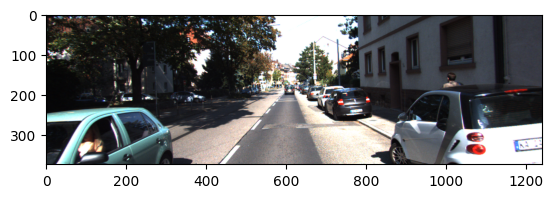

In [8]:
plt.imshow(img_plot)

In [10]:
# Print bboxes in image given a list of bboxes (x1, y1, x2, y2)
def plot_bboxes(img, bboxes, color=(0, 0, 255), thickness=5):
    img = img.copy()
    for bbox in bboxes:
        bbox = bbox.astype(int)
        cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness)
        break
    return img

tensor([ 2.7500,  1.6600, 14.2500,  3.7900,  1.5000,  1.5900, -1.6100])


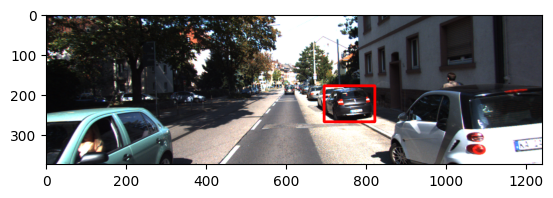

In [10]:
# Expand dims with numpy 
sample_id = 4
bboxes = data_sample.gt_instances.bboxes[sample_id]
bboxes = np.expand_dims(bboxes, axis=0)
img_bboxes = plot_bboxes(img, bboxes)
img_bboxes = torch.Tensor(img_bboxes).to(torch.uint8)[:, :, [2, 1, 0]]
plt.imshow(img_bboxes)
# (x, y, z, x_size, y_size, z_size, yaw)
print(data_sample.gt_instances_3d.bboxes_3d.tensor[sample_id])

## 3D bboxes

### Own

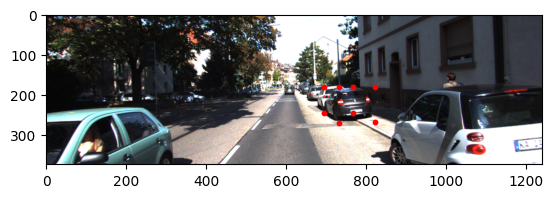

In [11]:
lidar2img = data_sample.lidar2img
cam2img = np.array(data_sample.cam2img)
lidar2cam = data_sample.lidar2cam

corners = data_sample.gt_instances_3d.bboxes_3d.corners[sample_id].T.numpy()
img_corners = np.dot(cam2img, np.concatenate([corners, np.ones((1, 8))], axis=0))
# Normalize by z-coordinate
img_corners = img_corners / img_corners[2, :]

plt.imshow(img_plot)
# Print dots in image
plt.scatter(img_corners[0], img_corners[1], c='r', s=10)

### MMDetection3D

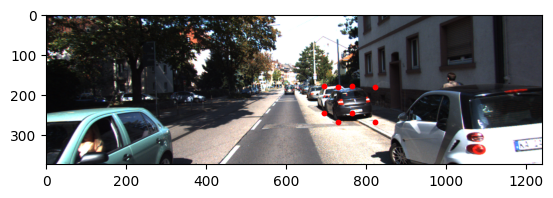

In [12]:
input_meta = {'cam2img': cam2img}
mmdet_corners = proj_camera_bbox3d_to_img(data_sample.gt_instances_3d.bboxes_3d, input_meta)
plt.imshow(img_plot)
plt.scatter(mmdet_corners[sample_id].T[0], mmdet_corners[sample_id].T[1], c='r', s=10)

In [15]:
def get_corners(bbox):
    bbox = bbox.cpu().numpy()
    x, y, z, x_size, y_size, z_size, yaw = bbox
    x_corners = np.array([x_size/2, x_size/2, -x_size/2, -x_size/2, x_size/2, x_size/2, -x_size/2, -x_size/2])
    y_corners = np.array([y_size/2, y_size/2, y_size/2, y_size/2, -y_size/2, -y_size/2, -y_size/2, -y_size/2])
    zeros = 0
    z_corners = np.array([zeros, z_size, z_size, zeros, zeros, z_size, z_size, zeros])

    corners = np.concatenate([x_corners[None, :], y_corners[None, :], z_corners[None, :]], axis=0)

    # Rotate corners
    # R = np.array([[np.cos(yaw), -np.sin(yaw), 0],
    #               [np.sin(yaw), np.cos(yaw), 0],
    #               [0, 0, 1]])
    
    # Rotate corners around y-axis
    R = np.array([[np.cos(yaw), 0, np.sin(yaw)],
                  [0, 1, 0],
                  [-np.sin(yaw), 0, np.cos(yaw)]])

    
    corners = np.dot(R, corners)
    corners[0, :] += x
    corners[1, :] += y
    corners[2, :] += z
    return corners

# DAIR-V2X mono3d

## 2D bboxes

In [8]:
config_path = osp.join(configs.__path__[0], '_base_', 'datasets',
    'dair-infrastructure-mono3d.py')
cfg = build_data_cfg(config_path, False, None)
init_default_scope(cfg.get('default_scope', 'mmdet3d'))
# vis_task = 'mono_det'
vis_task = 'lidar_det'
dataset = DATASETS.build(
    cfg.train_dataloader.dataset,
    default_args=dict(filter_empty_gt=False))

03/06 22:52:03 - mmengine - INFO - ------------------------------
03/06 22:52:03 - mmengine - INFO - The length of training dataset: 8800
03/06 22:52:03 - mmengine - INFO - The number of instances per category in the dataset:
+------------+--------+
| category   | number |
+------------+--------+
| Pedestrian | 19393  |
| Cyclist    | 9293   |
| Car        | 94692  |
+------------+--------+


In [9]:
for i, item in enumerate(dataset):
    # the 3D Boxes in input could be in any of three coordinates
    data_input = item['inputs']
    data_sample = item['data_samples'].numpy()
    # if i == 230:
    break
# Change to RGB
img = data_input['img'].permute(1, 2, 0).to(torch.uint8).numpy()
img_plot = data_input['img'].permute(1, 2, 0)[:, :, [2, 1, 0]]

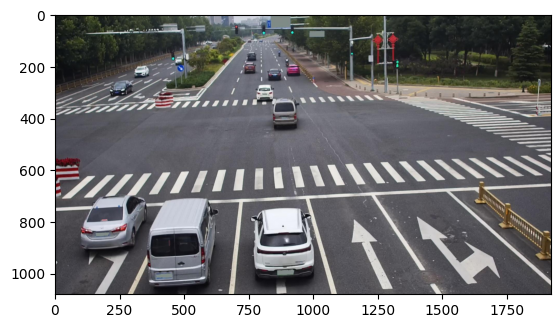

In [10]:
plt.imshow(img_plot)

In [11]:
# Print bboxes in image given a list of bboxes (x1, y1, x2, y2)
def plot_bboxes(img, bboxes, color=(0, 0, 255), thickness=5):
    img = img.copy()
    for bbox in bboxes:
        bbox = bbox.astype(int)
        cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness)
        break
    return img

tensor([-8.8195e-01,  2.8954e+00,  2.1462e+01,  1.8049e+00,  1.6888e+00,
         4.2341e+00,  2.0902e-02])


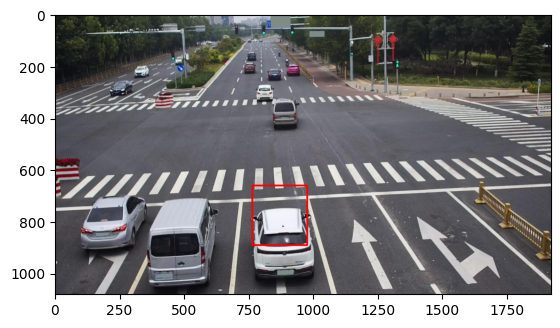

In [12]:
# Expand dims with numpy 
sample_id = 0
bboxes = data_sample.gt_instances.bboxes[sample_id]
bboxes = np.expand_dims(bboxes, axis=0)
img_bboxes = plot_bboxes(img, bboxes)
img_bboxes = torch.Tensor(img_bboxes).to(torch.uint8)[:, :, [2, 1, 0]]
plt.imshow(img_bboxes)
# (x, y, z, x_size, y_size, z_size, yaw)
print(data_sample.gt_instances_3d.bboxes_3d.tensor[sample_id])

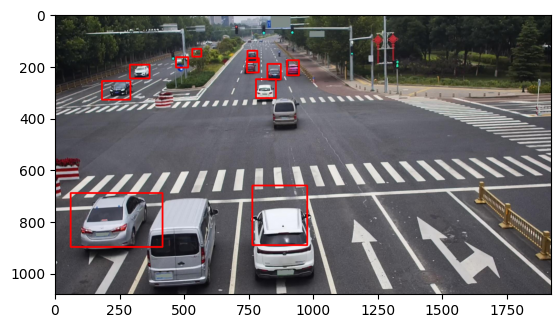

In [13]:
img_bboxes = copy.deepcopy(img)
for bbox in data_sample.gt_instances.bboxes:
    bbox = np.expand_dims(bbox, axis=0)
    img_bboxes = plot_bboxes(img_bboxes, bbox)

img_bboxes = torch.Tensor(img_bboxes).to(torch.uint8)[:, :, [2, 1, 0]]
plt.imshow(img_bboxes)

## 3D bboxes

In [17]:
lidar2img = data_sample.lidar2img
cam2img = np.array(data_sample.cam2img)
lidar2cam = data_sample.lidar2cam

corners_full = data_sample.gt_instances_3d.bboxes_3d.corners.T.numpy()

corners_full = np.concatenate([corners_full, np.ones((1, 8, corners_full.shape[2]))], axis=0)
corners_full = corners_full.reshape(4, -1)
# corners_full = np.dot(cam2img, corners_full)
corners_full = np.dot(lidar2img, corners_full)
corners_full = corners_full.reshape(4, 8, -1)
corners_full = corners_full / corners_full[2, :, :]
corners_full.shape

(4, 8, 11)

In [18]:
corners_full[:, :, 0]

array([[ 5.06751220e+03,  4.60473441e+03,  5.28182907e+03,
         5.83617419e+03,  8.25711734e+03,  6.83767316e+03,
         7.82833474e+03,  9.44750685e+03],
       [ 5.63774904e+03,  6.61930748e+03,  6.45620601e+03,
         5.47360380e+03,  9.81845075e+03,  1.04851261e+04,
         1.01013488e+04,  9.36215444e+03],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00],
       [-2.42961138e-01, -2.10265363e-01, -2.05856288e-01,
        -2.37093385e-01, -4.25768093e-01, -3.34592875e-01,
        -3.23564951e-01, -4.08070121e-01]])

In [19]:
corners_full[:, :, 0]

array([[ 5.06751220e+03,  4.60473441e+03,  5.28182907e+03,
         5.83617419e+03,  8.25711734e+03,  6.83767316e+03,
         7.82833474e+03,  9.44750685e+03],
       [ 5.63774904e+03,  6.61930748e+03,  6.45620601e+03,
         5.47360380e+03,  9.81845075e+03,  1.04851261e+04,
         1.01013488e+04,  9.36215444e+03],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00],
       [-2.42961138e-01, -2.10265363e-01, -2.05856288e-01,
        -2.37093385e-01, -4.25768093e-01, -3.34592875e-01,
        -3.23564951e-01, -4.08070121e-01]])

In [20]:
lidar2cam

array([[-0.06380332, -0.99109149, -0.04429948, -5.77914429],
       [-0.21028735,  0.04399769, -0.7987693 ,  6.03761578],
       [ 0.97575116, -0.06031492, -0.17158543,  1.06364238],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

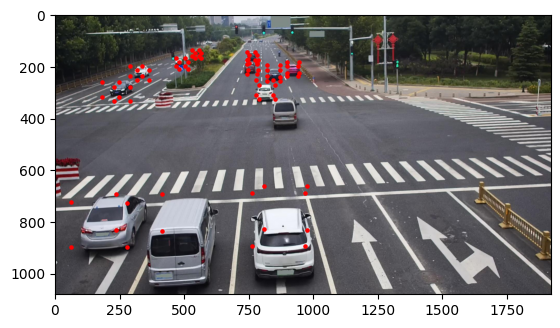

In [21]:
lidar2img = data_sample.lidar2img
cam2img = np.array(data_sample.cam2img)
lidar2cam = data_sample.lidar2cam

corners = data_sample.gt_instances_3d.bboxes_3d.corners.T.numpy()
corners = np.concatenate([corners, np.ones((1, 8, corners_full.shape[2]))], axis=0)
corners = corners.reshape(4, -1)
img_corners = np.dot(cam2img, corners)
# img_corners = np.dot(lidar2img, corners)
img_corners = img_corners.reshape(4, 8, -1)
img_corners = img_corners / img_corners[2, :]

plt.imshow(img_plot)
# Print dots in image
for i in range(img_corners.shape[2]):
    plt.scatter(img_corners[0, :, i], img_corners[1, :, i], c='r', s=5)
# plt.scatter(img_corners[0], img_corners[1], c='r', s=10)

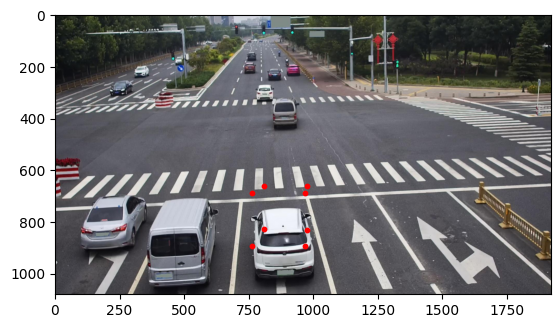

In [120]:
lidar2img = data_sample.lidar2img
cam2img = np.array(data_sample.cam2img)
lidar2cam = data_sample.lidar2cam

corners = data_sample.gt_instances_3d.bboxes_3d.corners[sample_id].T.numpy()
img_corners = np.dot(cam2img, np.concatenate([corners, np.ones((1, 8))], axis=0))
# Normalize by z-coordinate
img_corners = img_corners / img_corners[2, :]

plt.imshow(img_plot)
# Print dots in image
plt.scatter(img_corners[0], img_corners[1], c='r', s=10)

### Own

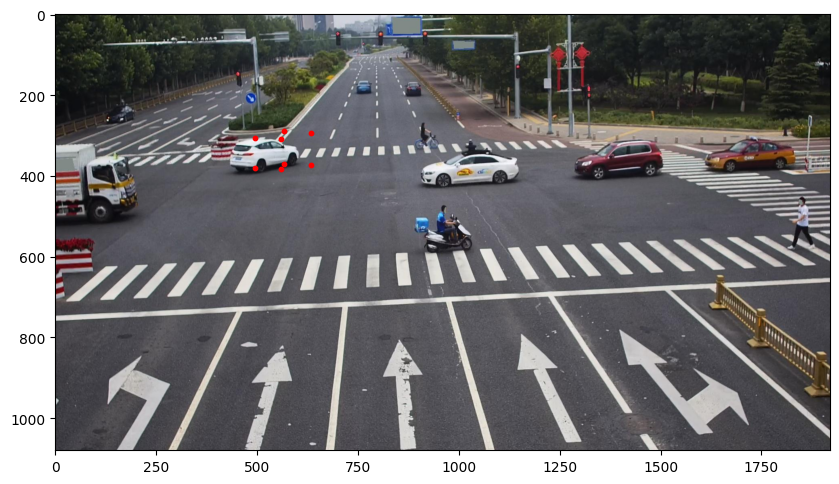

In [124]:
lidar2img = data_sample.lidar2img
cam2img = np.array(data_sample.cam2img)
lidar2cam = data_sample.lidar2cam

corners = data_sample.gt_instances_3d.bboxes_3d.corners[sample_id].T.numpy()
img_corners = np.dot(cam2img, np.concatenate([corners, np.ones((1, 8))], axis=0))
# Normalize by z-coordinate
img_corners = img_corners / img_corners[2, :]

# Fig size 
plt.figure(figsize=(10, 10))
plt.imshow(img_plot)
# Print dots in image
plt.scatter(img_corners[0], img_corners[1], c='r', s=10)

### MMDetection3D

In [125]:
data_sample.gt_instances_3d.bboxes_3d.tensor[sample_id]

tensor([-9.8784, -3.7800, 53.2162,  1.7281,  1.7661,  4.2709, -0.6070])

In [130]:
flip_horiz_roty(data_sample.gt_instances_3d.bboxes_3d.tensor)

tensor([[-1.0907e+01, -1.7877e+01,  1.1854e+02,  1.7372e+00,  1.5460e+00,
          4.1854e+00,  3.1937e-02],
        [-3.2687e+01, -1.0448e+01,  8.8400e+01,  2.0872e+00,  2.0810e+00,
          4.5032e+00, -3.1354e+00],
        [-9.8784e+00, -3.7800e+00,  5.3216e+01,  1.7281e+00,  1.7661e+00,
          4.2709e+00, -6.0696e-01],
        [ 1.1993e+01,  5.3980e-01,  3.0369e+01,  5.2517e-01,  1.7222e+00,
          5.2843e-01,  1.6242e+00],
        [ 1.1270e+00, -2.3424e+00,  4.4790e+01,  1.8530e+00,  1.9990e+00,
          4.8147e+00,  1.6454e+00],
        [-4.6893e-01, -5.3941e+00,  5.9375e+01,  5.2294e-01,  1.5138e+00,
          1.4895e+00,  1.8310e+00],
        [ 8.5842e+00, -2.7041e+00,  4.5165e+01,  1.7471e+00,  1.6396e+00,
          4.3399e+00,  1.6475e+00],
        [ 1.5277e+01, -3.0697e+00,  4.5886e+01,  1.7183e+00,  1.5422e+00,
          4.5261e+00,  1.5885e+00],
        [-3.9975e+00, -1.6404e+01,  1.1085e+02,  2.1115e+00,  1.5427e+00,
          4.4977e+00,  2.4024e-02]])

In [131]:
bboxes = copy.deepcopy(data_sample.gt_instances_3d.bboxes_3d.tensor)

In [132]:
bboxes

tensor([[-1.0907e+01, -1.7877e+01,  1.1854e+02,  1.7372e+00,  1.5460e+00,
          4.1854e+00,  3.1937e-02],
        [-3.2687e+01, -1.0448e+01,  8.8400e+01,  2.0872e+00,  2.0810e+00,
          4.5032e+00, -3.1354e+00],
        [-9.8784e+00, -3.7800e+00,  5.3216e+01,  1.7281e+00,  1.7661e+00,
          4.2709e+00, -6.0696e-01],
        [ 1.1993e+01,  5.3980e-01,  3.0369e+01,  5.2517e-01,  1.7222e+00,
          5.2843e-01,  1.6242e+00],
        [ 1.1270e+00, -2.3424e+00,  4.4790e+01,  1.8530e+00,  1.9990e+00,
          4.8147e+00,  1.6454e+00],
        [-4.6893e-01, -5.3941e+00,  5.9375e+01,  5.2294e-01,  1.5138e+00,
          1.4895e+00,  1.8310e+00],
        [ 8.5842e+00, -2.7041e+00,  4.5165e+01,  1.7471e+00,  1.6396e+00,
          4.3399e+00,  1.6475e+00],
        [ 1.5277e+01, -3.0697e+00,  4.5886e+01,  1.7183e+00,  1.5422e+00,
          4.5261e+00,  1.5885e+00],
        [-3.9975e+00, -1.6404e+01,  1.1085e+02,  2.1115e+00,  1.5427e+00,
          4.4977e+00,  2.4024e-02]])

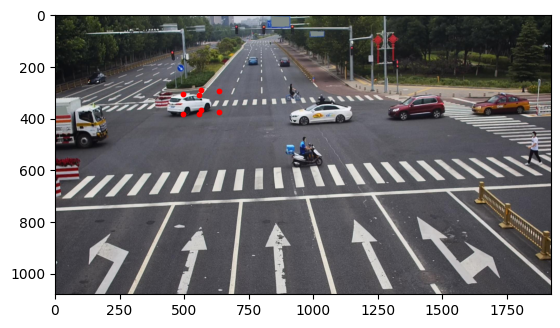

In [133]:
input_meta = {'cam2img': cam2img}
data_sample.gt_instances_3d.bboxes_3d.tensor = bboxes
mmdet_corners = proj_camera_bbox3d_to_img(data_sample.gt_instances_3d.bboxes_3d, input_meta)
plt.imshow(img_plot)
plt.scatter(mmdet_corners[sample_id].T[0], mmdet_corners[sample_id].T[1], c='r', s=10)

In [134]:
def get_rotation_matrix(alpha, axis):
    if axis == 'x':
        R = np.array([[1, 0, 0],
                      [0, np.cos(alpha), -np.sin(alpha)],
                      [0, np.sin(alpha), np.cos(alpha)]])
    elif axis == 'y':
        R = np.array([[np.cos(alpha), 0, np.sin(alpha)],
                      [0, 1, 0],
                      [-np.sin(alpha), 0, np.cos(alpha)]])
    elif axis == 'z':
        R = np.array([[np.cos(alpha), -np.sin(alpha), 0],
                      [np.sin(alpha), np.cos(alpha), 0],
                      [0, 0, 1]])
    return R

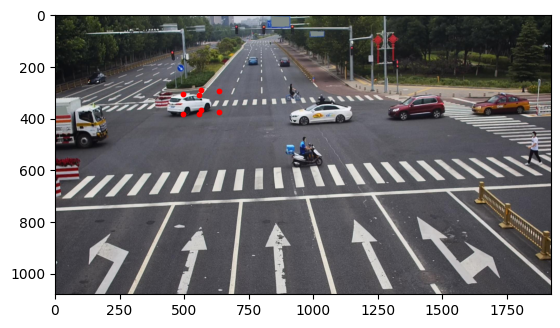

In [138]:
pitch = 0
pitch = np.deg2rad(pitch)
R = get_rotation_matrix(pitch, 'x')
T = np.eye(4)
T[:3, :3] = R

# input_meta = {'cam2img': cam2img}
input_meta = {'cam2img': np.dot(cam2img, np.linalg.inv(T))}
data_sample.gt_instances_3d.bboxes_3d.tensor = bboxes
mmdet_corners = proj_camera_bbox3d_to_img(data_sample.gt_instances_3d.bboxes_3d, input_meta)
plt.imshow(img_plot)
plt.scatter(mmdet_corners[sample_id].T[0], mmdet_corners[sample_id].T[1], c='r', s=10)

In [45]:
cam2img

array([[2.18635969e+03, 0.00000000e+00, 9.68712906e+02, 0.00000000e+00],
       [0.00000000e+00, 2.33216032e+03, 5.42356703e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

## Raw from DAIR labels

### Own

In [30]:
dair_example_path = '/home/breaststroker/datasets/DAIR-V2X/cooperative-vehicle-infrastructure-example/infrastructure-side/'
example_id = '000009'
img_path = osp.join(dair_example_path, 'image', example_id + '.jpg')
camera_label_path = osp.join(dair_example_path, 'label', 'camera', example_id + '.json')
lidar_label_path = osp.join(dair_example_path, 'label', 'virtuallidar', example_id + '.json')
camera_intrinsic_path = osp.join(dair_example_path, 'calib', 'camera_intrinsic', example_id + '.json')
lidar2cam_path = osp.join(dair_example_path, 'calib', 'virtuallidar_to_camera', example_id + '.json')

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
camera_label = json.load(open(camera_label_path, 'r'))
lidar_label = json.load(open(lidar_label_path, 'r'))
camera_intrinsic = json.load(open(camera_intrinsic_path, 'r'))
lidar2cam = json.load(open(lidar2cam_path, 'r'))

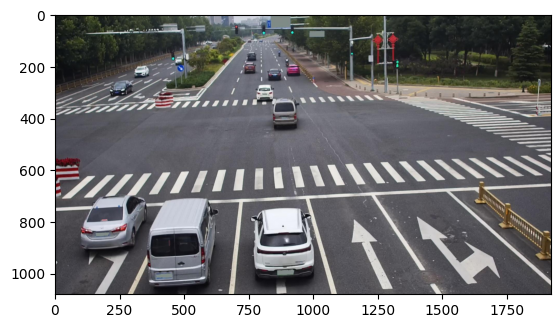

In [31]:
plt.imshow(img)

In [32]:
raw_cam2img = np.eye(4)
raw_cam2img[:3, :3] = np.array(camera_intrinsic['cam_K']).reshape([3, 3], order='C')
raw_cam2img

array([[2.18635969e+03, 0.00000000e+00, 9.68712906e+02, 0.00000000e+00],
       [0.00000000e+00, 2.33216032e+03, 5.42356703e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [33]:
np.array(lidar2cam['translation']).squeeze()

array([-5.7791444 ,  6.03761576,  1.0636424 ])

In [34]:
raw_lidar2cam = np.eye(4)
raw_lidar2cam[:3, :3] = np.array(lidar2cam['rotation'])
raw_lidar2cam[:3, 3] = np.array(lidar2cam['translation']).squeeze()
raw_lidar2cam

array([[-0.06380332, -0.99109149, -0.04429948, -5.7791444 ],
       [-0.21028734,  0.04399769, -0.79876929,  6.03761576],
       [ 0.97575115, -0.06031493, -0.17158543,  1.0636424 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [35]:
camera_label[0]

{'type': 'Car',
 'truncated_state': '0',
 'occluded_state': '0',
 'alpha': '0',
 '2d_box': {'xmin': 768.12085,
  'ymin': 747.97583,
  'xmax': 1002.4884040000001,
  'ymax': 1021.312134},
 '3d_dimensions': {'h': 0.955531, 'w': 2.036715, 'l': 4.234148},
 '3d_location': {'x': '20.233591', 'y': '-6.118915', 'z': '-1.906110'},
 'rotation': 0.02090169484402715}

In [36]:
# ! You have to load lidar2cam first
raw_cam2img

array([[2.18635969e+03, 0.00000000e+00, 9.68712906e+02, 0.00000000e+00],
       [0.00000000e+00, 2.33216032e+03, 5.42356703e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [37]:
raw_lidar2img = np.dot(raw_cam2img, raw_lidar2cam)
raw_lidar2img

array([[ 8.05725715e+02, -2.22531032e+03, -2.63071630e+02,
        -1.16049242e+04],
       [ 3.87813829e+01,  6.98974683e+01, -1.95591854e+03,
         1.46575615e+04],
       [ 9.75751146e-01, -6.03149254e-02, -1.71585432e-01,
         1.06364240e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [38]:
lidar_label[0]

{'type': 'Car',
 'truncated_state': '0',
 'occluded_state': '0',
 'alpha': '0',
 '2d_box': {'xmin': 768.12085,
  'ymin': 747.97583,
  'xmax': 1002.4884040000001,
  'ymax': 1021.312134},
 '3d_dimensions': {'h': 1.688849, 'w': 1.804866, 'l': 4.234148},
 '3d_location': {'x': 20.22032661649286,
  'y': -6.165649086415965,
  'z': -0.8846375190174429},
 'rotation': 0.02090180743721963}

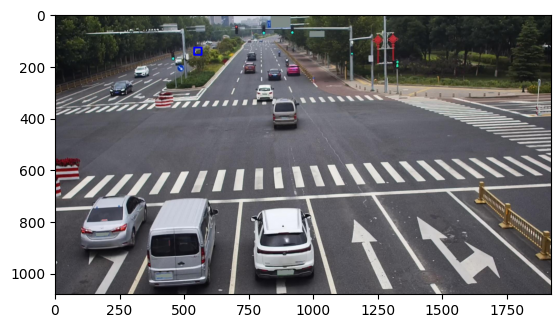

In [40]:
bboxes_2d = camera_label[1]['2d_box']
bboxes_2d = [bboxes_2d['xmin'], bboxes_2d['ymin'], bboxes_2d['xmax'], bboxes_2d['ymax']]
bboxes_2d = np.array(bboxes_2d)
img_bboxes = plot_bboxes(img, [bboxes_2d])
plt.imshow(img_bboxes)

In [41]:
cam_coords = camera_label[13]['3d_location']
cam_coords = [float(cam_coords['x']), float(cam_coords['y']), float(cam_coords['z'])]
bboxes_3d = np.array(cam_coords)
# Transform to homogeneous coordinates
bboxes_3d = np.concatenate([bboxes_3d, np.ones(1)])
point = np.dot(raw_lidar2img, bboxes_3d) / np.dot(raw_lidar2img, bboxes_3d)[2]

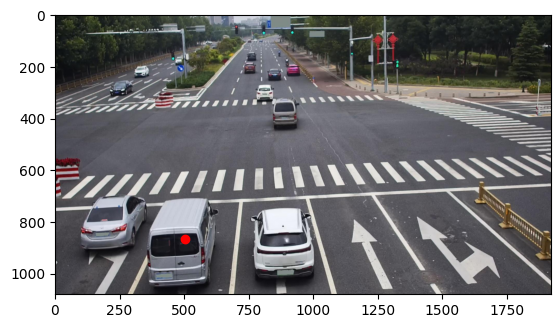

In [42]:
plt.imshow(img)
plt.plot(point[0], point[1], 'ro')

In [26]:
def get_label(label):
    h = float(label[0]["h"])
    w = float(label[0]["w"])
    length = float(label[0]["l"])
    x = float(label[1]["x"])
    y = float(label[1]["y"])
    z = float(label[1]["z"])
    rotation_y = float(label[-1])
    return h, w, length, x, y, z, rotation_y


def compute_corners_3d(dim, rotation_y):
    c, s = np.cos(rotation_y), np.sin(rotation_y)
    R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]], dtype=np.float32)
    # R = np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]], dtype=np.float32)
    l, w, h = dim[0], dim[1], dim[2]
    x_corners = [-l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2]
    y_corners = [w / 2, w / 2, w / 2, w / 2, -w / 2, -w / 2, -w / 2, -w / 2]
    z_corners = [h, h, 0, 0, h, h, 0, 0]
    corners = np.array([x_corners, y_corners, z_corners], dtype=np.float32)
    corners_3d = np.dot(R, corners).transpose(1, 0)

    return corners_3d


def compute_box_3d(dim, location, rotation_y):
    # dim: 3
    # location: 3
    # rotation_y: 1
    # return: 8 x 3
    corners_3d = compute_corners_3d(dim, rotation_y)
    corners_3d = corners_3d + np.array(location, dtype=np.float32).reshape(1, 3)

    return corners_3d


def get_lidar2cam(calib):
    if "Tr_velo_to_cam" in calib.keys():
        velo2cam = np.array(calib["Tr_velo_to_cam"]).reshape(3, 4)
        r_velo2cam = velo2cam[:, :3]
        t_velo2cam = velo2cam[:, 3].reshape(3, 1)
    else:
        r_velo2cam = np.array(calib["rotation"])
        t_velo2cam = np.array(calib["translation"])
    return r_velo2cam, t_velo2cam


def get_cam_8_points(labels, calib_lidar2cam_path):
    """Plot the boundaries of 3D BBox with label on 2D image.

        Args:
            label: h, w, l, x, y, z, rotaion
            image_path: Path of image to be visualized
            calib_lidar2cam_path: Extrinsic of lidar2camera
            calib_intrinsic_path: Intrinsic of camera
            save_path: Save path for visualized images

    ..code - block:: none


                         front z
                              /
                             /
               (x0, y0, z1) + -----------  + (x1, y0, z1)
                           /|            / |
                          / |           /  |
            (x0, y0, z0) + ----------- +   + (x1, y1, z1)
                         |  /      .   |  /
                         | / oriign    | /
            (x0, y1, z0) + ----------- + -------> x right
                         |             (x1, y1, z0)
                         |
                         v
                    down y

    """
    calib_lidar2cam = json.load(open(calib_lidar2cam_path, 'r'))
    # calib_lidar2cam = read_json(calib_lidar2cam_path)
    r_velo2cam, t_velo2cam = get_lidar2cam(calib_lidar2cam)
    camera_8_points_list = []
    for label in labels:
        h, w, l, x, y, z, yaw_lidar = get_label(label)
        z = z - h / 2
        bottom_center = [x, y, z]
        obj_size = [l, w, h]
        lidar_8_points = compute_box_3d(obj_size, bottom_center, yaw_lidar)
        # lidar_8_points = np.matrix([[x - l / 2, y + w / 2, z + h],
        #                             [x + l / 2, y + w / 2, z + h],
        #                             [x + l / 2, y + w / 2, z],
        #                             [x - l / 2, y + w / 2, z],
        #                             [x - l / 2, y - w / 2, z + h],
        #                             [x + l / 2, y - w / 2, z + h],
        #                             [x + l / 2, y - w / 2, z],
        #                             [x - l / 2, y - w / 2, z]])
        camera_8_points = r_velo2cam * np.matrix(lidar_8_points).T + t_velo2cam
        camera_8_points_list.append(camera_8_points.T)

    return camera_8_points_list


def points_cam2img(points_3d, calib_intrinsic, with_depth=False):
    """Project points from camera coordicates to image coordinates.

    points_3d: N x 8 x 3
    calib_intrinsic: 3 x 4
    return: N x 8 x 2
    """
    points_num = list(points_3d.shape)[:-1]
    points_shape = np.concatenate([points_num, [1]], axis=0)
    points_2d_shape = np.concatenate([points_num, [3]], axis=0)
    # assert len(calib_intrinsic.shape) == 2, 'The dimension of the projection' \
    #                                  f' matrix should be 2 instead of {len(calib_intrinsic.shape)}.'
    # d1, d2 = calib_intrinsic.shape[:2]
    # assert (d1 == 3 and d2 == 3) or (d1 == 3 and d2 == 4) or (
    #         d1 == 4 and d2 == 4), 'The shape of the projection matrix' \
    #                               f' ({d1}*{d2}) is not supported.'
    # if d1 == 3:
    #     calib_intrinsic_expanded = np.eye(4, dtype=calib_intrinsic.dtype)
    #     calib_intrinsic_expanded[:d1, :d2] = calib_intrinsic
    #     calib_intrinsic = calib_intrinsic_expanded

    # previous implementation use new_zeros, new_one yeilds better results

    points_4 = np.concatenate((points_3d, np.ones(points_shape)), axis=-1)
    point_2d = np.matmul(calib_intrinsic, points_4.T.swapaxes(1, 2).reshape(4, -1))
    point_2d = point_2d.T.reshape(points_2d_shape)
    point_2d_res = point_2d[..., :2] / point_2d[..., 2:3]

    if with_depth:
        return np.cat([point_2d_res, point_2d[..., 2:3]], dim=-1)
    return point_2d_res

In [37]:
get_label([camera_label[0]['3d_dimensions'], camera_label[0]['3d_location'], camera_label[0]['rotation']])

(0.955531,
 2.036715,
 4.234148,
 20.233591,
 -6.118915,
 -1.90611,
 0.02090169484402715)

In [38]:
labels = [[camera_label[i]['3d_dimensions'], camera_label[i]['3d_location'], camera_label[i]['rotation']] for i in range(len(camera_label))]
cam_8_points = np.array(get_cam_8_points(labels, lidar2cam_path))

In [39]:
raw_cam2img[:3, :].shape

(3, 4)

In [40]:
bboxes_2d = points_cam2img(cam_8_points, raw_cam2img[:3, :])

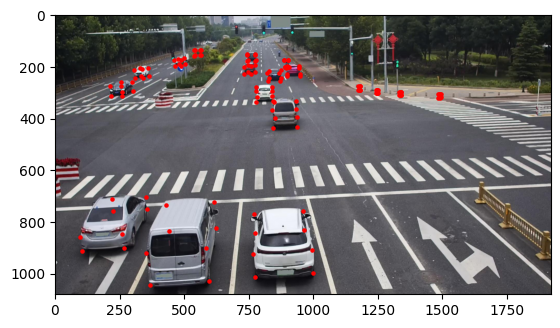

In [41]:
plt.imshow(img)
for bbox in bboxes_2d:
    for x, y in bbox:
        plt.scatter(x, y, c='r', s=5)

In [42]:
raw_cam2img

array([[2.18635969e+03, 0.00000000e+00, 9.68712906e+02, 0.00000000e+00],
       [0.00000000e+00, 2.33216032e+03, 5.42356703e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [62]:
raw_lidar2cam

array([[-0.06380332, -0.99109149, -0.04429948, -5.7791444 ],
       [-0.21028734,  0.04399769, -0.79876929,  6.03761576],
       [ 0.97575115, -0.06031493, -0.17158543,  1.0636424 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [61]:
[-0.0638033225610772, -0.9910914864003576, -0.04429948490729328, -5.779144404715124, -0.2102873406178483, 0.043997692433495696, -0.7987692871343754, 6.037615758600886, 0.97575114561348, -0.06031492538699515, -0.17158543199893228, 1.0636424034755758]

[-0.0638033225610772,
 -0.9910914864003576,
 -0.04429948490729328,
 -5.779144404715124,
 -0.2102873406178483,
 0.043997692433495696,
 -0.7987692871343754,
 6.037615758600886,
 0.97575114561348,
 -0.06031492538699515,
 -0.17158543199893228,
 1.0636424034755758]

### MMDetection3D

In [43]:
dair_example_path = '/home/breaststroker/datasets/DAIR-V2X/cooperative-vehicle-infrastructure-example/infrastructure-side/'
example_id = '000009'
img_path = osp.join(dair_example_path, 'image', example_id + '.jpg')
camera_label_path = osp.join(dair_example_path, 'label', 'camera', example_id + '.json')
lidar_label_path = osp.join(dair_example_path, 'label', 'virtuallidar', example_id + '.json')
camera_intrinsic_path = osp.join(dair_example_path, 'calib', 'camera_intrinsic', example_id + '.json')
lidar2cam_path = osp.join(dair_example_path, 'calib', 'virtuallidar_to_camera', example_id + '.json')

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
camera_label = json.load(open(camera_label_path, 'r'))
lidar_label = json.load(open(lidar_label_path, 'r'))
camera_intrinsic = json.load(open(camera_intrinsic_path, 'r'))
lidar2cam = json.load(open(lidar2cam_path, 'r'))

sample_id = 0

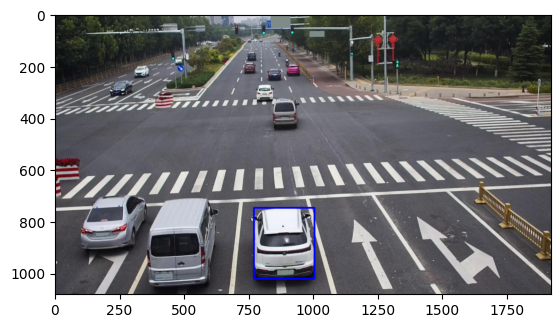

In [44]:
bboxes_2d = camera_label[sample_id]['2d_box']
bboxes_2d = [bboxes_2d['xmin'], bboxes_2d['ymin'], bboxes_2d['xmax'], bboxes_2d['ymax']]
bboxes_2d = np.array(bboxes_2d)
img_bboxes = plot_bboxes(img, [bboxes_2d])
plt.imshow(img_bboxes)

In [45]:
raw_cam2img = np.eye(4)
raw_cam2img[:3, :3] = np.array(camera_intrinsic['cam_K']).reshape([3, 3], order='C')

raw_lidar2cam = np.eye(4)
raw_lidar2cam[:3, :3] = np.array(lidar2cam['rotation'])
raw_lidar2cam[:3, 3] = np.array(lidar2cam['translation']).squeeze()

raw_lidar2img = np.dot(raw_cam2img, raw_lidar2cam)
raw_lidar2img

array([[ 8.05725715e+02, -2.22531032e+03, -2.63071630e+02,
        -1.16049242e+04],
       [ 3.87813829e+01,  6.98974683e+01, -1.95591854e+03,
         1.46575615e+04],
       [ 9.75751146e-01, -6.03149254e-02, -1.71585432e-01,
         1.06364240e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [46]:
labels = [list(get_label([camera_label[i]['3d_dimensions'], 
           camera_label[i]['3d_location'], 
           camera_label[i]['rotation']])) for i in range(len(camera_label))]
labels = [label[3:6] + [label[2], label[1], label[0]] + label[6:] for label in labels]
labels = np.array(labels)
labels[:, 1] = labels[:, 1] + labels[:, 4] / 2

In [47]:
labels[0]

array([20.233591  , -5.1005575 , -1.90611   ,  4.234148  ,  2.036715  ,
        0.955531  ,  0.02090169])

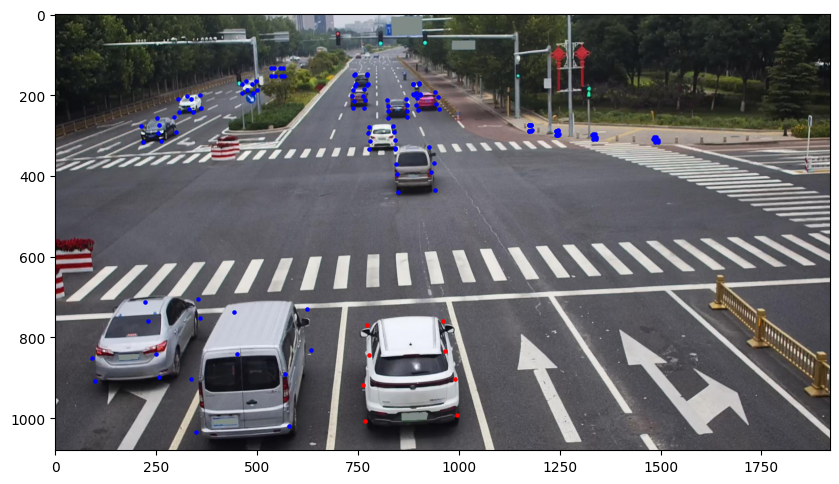

In [48]:
input_meta = {'cam2img': raw_lidar2img}
camera_instances = CameraInstance3DBoxes(labels)
mmdet_corners = proj_camera_bbox3d_to_img(camera_instances, input_meta)
plt.figure(figsize=(10, 10))
plt.imshow(img)
for i, bbox in enumerate(mmdet_corners):
    for x, y in bbox:
        if i == sample_id:
            plt.scatter(x, y, c='r', s=5)
        else:
            plt.scatter(x, y, c='b', s=5)
# plt.scatter(mmdet_corners[sample_id].T[0], mmdet_corners[sample_id].T[1], c='r', s=10)

In [49]:
np.dot(raw_lidar2cam, np.concatenate([corners, np.ones((1, 8))], axis=0))

NameError: name 'corners' is not defined

In [159]:
corners

array([[-8.768533 , -8.841912 , -8.841912 , -8.768533 , 11.486966 ,
        11.413587 , 11.413587 , 11.486966 ],
       [ 4.476422 ,  4.476422 ,  1.96818  ,  1.96818  ,  4.476422 ,
         4.476422 ,  1.96818  ,  1.96818  ],
       [ 6.411628 ,  4.8217244,  4.8217244,  6.411628 ,  5.476768 ,
         3.8868644,  3.8868644,  5.476768 ]], dtype=float32)

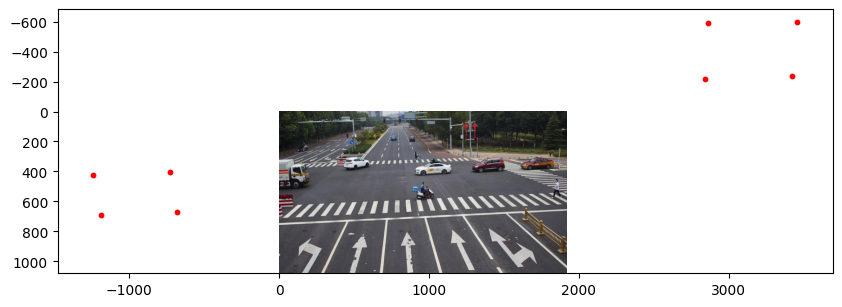

In [163]:
corners = camera_instances.corners[sample_id].T.numpy()
img_corners = np.dot(raw_lidar2img, np.concatenate([corners, np.ones((1, 8))], axis=0))
# Normalize by z-coordinate
img_corners = img_corners / img_corners[2, :]

# Fig size 
plt.figure(figsize=(10, 10))
plt.imshow(img_plot)
# Print dots in image
plt.scatter(img_corners[0], img_corners[1], c='r', s=10)

In [ ]:
# DAIR-V2X labels are (h, w, l, x, y, z, rotation_y)
# bboxes are in lidar coordinates (x (front), y (left), z (up))

In [139]:
# "distant left" vehicle
labels[sample_id]

array([  1.808188  ,   1.84768   ,   4.326902  , 177.119712  ,
        16.117218  ,  -1.127131  ,  -3.09547717])

In [ ]:
# "center" vehicle
labels[sample_id]

array([ 0.955531  ,  2.036715  ,  4.234148  , 20.233591  , -6.118915  ,
       -1.90611   ,  0.02090169])

In [ ]:
# "left" van
labels[sample_id]

array([ 1.322527  ,  1.96818   ,  5.149246  , 20.27706   , -2.508242  ,
       -1.591596  ,  0.04612066])

In [107]:
data_sample.gt_instances_3d.bboxes_3d.corners

tensor([[[-11.8419, -19.4230, 116.4809],
         [-11.7083, -19.4230, 120.6642],
         [-11.7083, -17.8770, 120.6642],
         [-11.8419, -17.8770, 116.4809],
         [-10.1056, -19.4230, 116.4255],
         [ -9.9719, -19.4230, 120.6087],
         [ -9.9719, -17.8770, 120.6087],
         [-10.1056, -17.8770, 116.4255]],

        [[-31.6294, -12.5287,  90.6455],
         [-31.6574, -12.5287,  86.1424],
         [-31.6574, -10.4477,  86.1424],
         [-31.6294, -10.4477,  90.6455],
         [-33.7166, -12.5287,  90.6585],
         [-33.7446, -12.5287,  86.1553],
         [-33.7446, -10.4477,  86.1553],
         [-33.7166, -10.4477,  90.6585]],

        [[ -9.3701,  -5.5461,  50.9694],
         [-11.8060,  -5.5461,  54.4774],
         [-11.8060,  -3.7800,  54.4774],
         [ -9.3701,  -3.7800,  50.9694],
         [ -7.9507,  -5.5461,  51.9550],
         [-10.3866,  -5.5461,  55.4631],
         [-10.3866,  -3.7800,  55.4631],
         [ -7.9507,  -3.7800,  51.9550]],

        [[

## Raw from kittiformat labels

### Own

In [66]:
kittiformat_example_path = '/home/breaststroker/datasets/DAIR-V2X/cooperative-vehicle-infrastructure-kittiformat/infrastructure-side/training/'
example_id = '000009'
img_path = osp.join(kittiformat_example_path, 'image_2', example_id + '.jpg')
label_path = osp.join(kittiformat_example_path, 'label_2', example_id + '.txt')
calib_path = osp.join(kittiformat_example_path, 'calib', example_id + '.txt')

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
label = np.loadtxt(label_path, dtype=str, delimiter=' ')
calib = open(calib_path, 'r').readlines()

In [67]:
bboxes_2d = label[:, 4:8].astype(float)
bboxes_3d = label[:, 8:].astype(float)

In [68]:
bboxes_3d

array([[ 1.68884900e+00,  4.23414800e+00,  1.80486600e+00,
        -8.81949552e-01,  2.89538435e+00,  2.14622118e+01,
         2.09018074e-02],
       [ 1.52829400e+00,  4.31033700e+00,  2.02064700e+00,
        -3.33285919e+01, -2.84121145e+01,  1.73370666e+02,
         3.12408147e+00],
       [ 1.98408200e+00,  4.57113200e+00,  1.93920800e+00,
        -1.45971537e+00, -2.66310980e+00,  4.66514031e+01,
        -3.88277025e-02],
       [ 1.78585300e+00,  4.37728300e+00,  1.91170300e+00,
        -1.26820898e+01, -2.09455676e+01,  1.34500468e+02,
         9.26978435e-03],
       [ 1.67273400e+00,  1.75437900e+00,  5.29791000e-01,
        -3.44209663e+00, -1.64704102e+01,  1.11619429e+02,
         3.03221118e-03],
       [ 1.65180500e+00,  4.24574500e+00,  1.82366100e+00,
        -2.07446627e+00, -1.23024567e+01,  9.15886289e+01,
        -5.03116413e-02],
       [ 4.49620000e-01,  2.22651000e-01,  2.19005000e-01,
         1.03597153e+01, -6.06946146e+00,  6.14083402e+01,
         8.8610115

In [69]:
cam2img = calib[0][4:-1]
lidar2cam = calib[5][16:]
print(cam2img)
# Transform string with ' ' delimiters to array
cam2img = np.array(cam2img.split(' ')).astype(float).reshape(3, 4)
lidar2cam = np.array(lidar2cam.split(' ')).astype(float).reshape(3, 4)
tmp = np.eye(4)
tmp[:3, :4] = cam2img
cam2img = tmp
tmp = np.eye(4)
tmp[:3, :4] = lidar2cam
lidar2cam = tmp

2186.359688 0.0 968.712906 0.0 0.0 2332.160319 542.356703 0.0 0.0 0.0 1.0 0.0


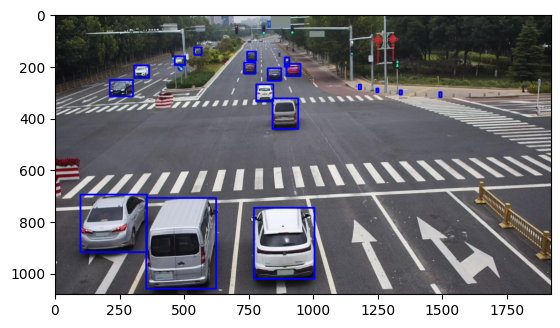

In [70]:
img_bboxes = copy.deepcopy(img)
for bbox in bboxes_2d:
    img_bboxes = plot_bboxes(img_bboxes, [bbox])
plt.imshow(img_bboxes)

In [71]:
bboxes_2d = label[:, 4:8].astype(float)
bboxes_3d = label[:, 8:].astype(float)
tmp = [2, 0, 1]
bboxes_3d = np.concatenate([bboxes_3d[:, 3:6], 
                            bboxes_3d[:, tmp[0]:tmp[0]+1],
                            bboxes_3d[:, tmp[1]:tmp[1]+1],
                            bboxes_3d[:, tmp[2]:tmp[2]+1],
                            bboxes_3d[:, 6:7]], axis=1)

In [72]:
cam2img

array([[2.18635969e+03, 0.00000000e+00, 9.68712906e+02, 0.00000000e+00],
       [0.00000000e+00, 2.33216032e+03, 5.42356703e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [73]:
labels[0]

array([20.233591  , -5.1005575 , -1.90611   ,  4.234148  ,  2.036715  ,
        0.955531  ,  0.02090169])

In [74]:
bboxes_3d[0]

array([-8.81949552e-01,  2.89538435e+00,  2.14622118e+01,  1.80486600e+00,
        1.68884900e+00,  4.23414800e+00,  2.09018074e-02])

In [75]:
lidar2img = np.dot(cam2img, lidar2cam)

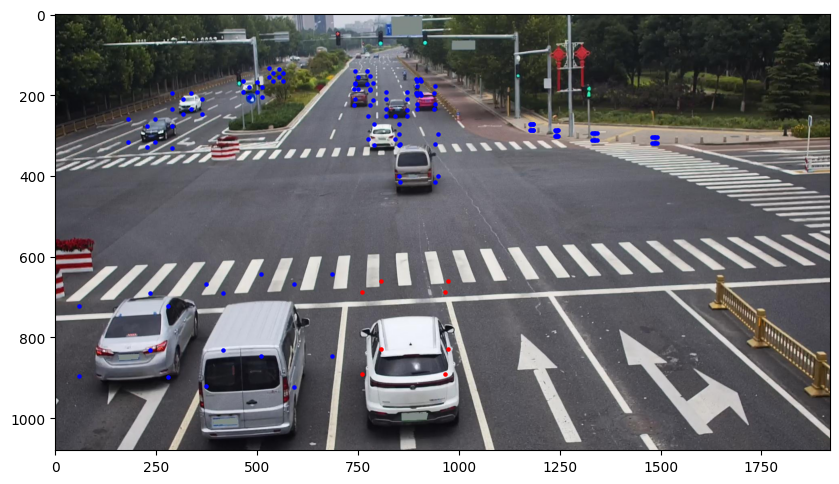

In [80]:
sample_id = 0
input_meta = {'cam2img': cam2img}
camera_instances = CameraInstance3DBoxes(bboxes_3d)
# lidar_instances = LiDARInstance3DBoxes(bboxes_3d)
mmdet_corners = proj_camera_bbox3d_to_img(camera_instances, input_meta)
# mmdet_corners = proj_camera_bbox3d_to_img(lidar_instances, input_meta)
plt.figure(figsize=(10, 10))
plt.imshow(img)
for i, bbox in enumerate(mmdet_corners):
    for x, y in bbox:
        if i == sample_id:
            plt.scatter(x, y, c='r', s=5)
        else:
            plt.scatter(x, y, c='b', s=5)
# plt.scatter(mmdet_corners[sample_id].T[0], mmdet_corners[sample_id].T[1], c='r', s=10)

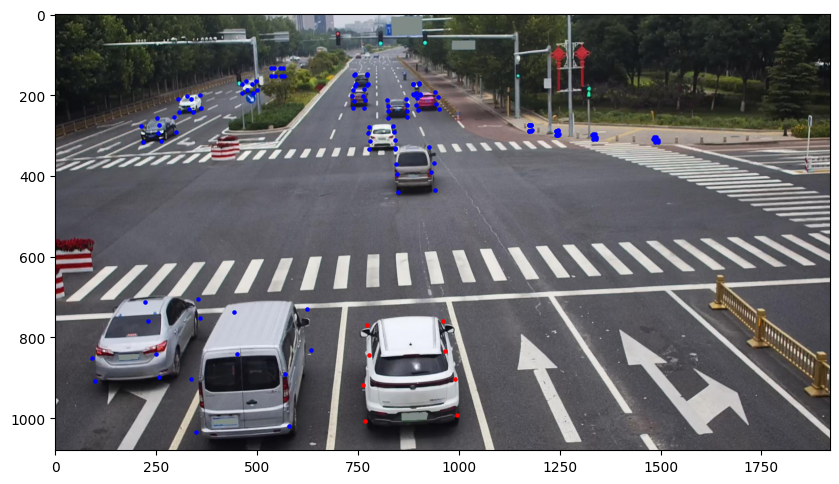

In [58]:
input_meta = {'cam2img': lidar2img}
camera_instances = CameraInstance3DBoxes(labels)
mmdet_corners = proj_camera_bbox3d_to_img(camera_instances, input_meta)
plt.figure(figsize=(10, 10))
plt.imshow(img)
for i, bbox in enumerate(mmdet_corners):
    for x, y in bbox:
        if i == sample_id:
            plt.scatter(x, y, c='r', s=5)
        else:
            plt.scatter(x, y, c='b', s=5)
# plt.scatter(mmdet_corners[sample_id].T[0], mmdet_corners[sample_id].T[1], c='r', s=10)

# DAIR-V2X vehicle side

In [181]:
config_path = osp.join(configs.__path__[0], '_base_', 'datasets',
    'dair-vehicle-mono3d.py')
cfg = build_data_cfg(config_path, False, None)
init_default_scope(cfg.get('default_scope', 'mmdet3d'))
# vis_task = 'mono_det'
vis_task = 'lidar_det'
dataset = DATASETS.build(
    cfg.train_dataloader.dataset,
    default_args=dict(filter_empty_gt=False))

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
for i, item in enumerate(dataset):
    # the 3D Boxes in input could be in any of three coordinates
    data_input = item['inputs']
    data_sample = item['data_samples'].numpy()
    # if i == 230:
    break
# Change to RGB
img = data_input['img'].permute(1, 2, 0).to(torch.uint8).numpy()
img_plot = data_input['img'].permute(1, 2, 0)[:, :, [2, 1, 0]]

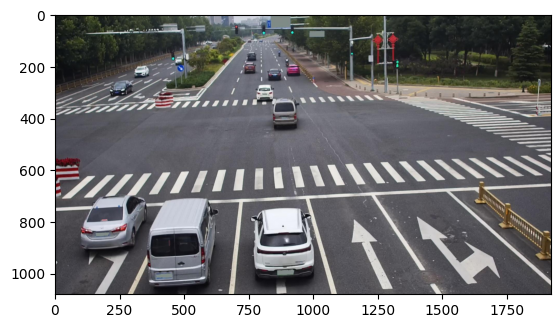

In [ ]:
plt.imshow(img_plot)

In [ ]:
# Print bboxes in image given a list of bboxes (x1, y1, x2, y2)
def plot_bboxes(img, bboxes, color=(0, 0, 255), thickness=5):
    img = img.copy()
    for bbox in bboxes:
        bbox = bbox.astype(int)
        cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness)
        break
    return img

tensor([-8.8195e-01,  2.8954e+00,  2.1462e+01,  1.8049e+00,  1.6888e+00,
         4.2341e+00,  2.0902e-02])


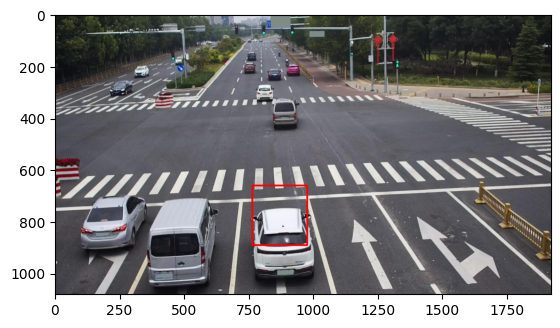

In [ ]:
# Expand dims with numpy 
sample_id = 0
bboxes = data_sample.gt_instances.bboxes[sample_id]
bboxes = np.expand_dims(bboxes, axis=0)
img_bboxes = plot_bboxes(img, bboxes)
img_bboxes = torch.Tensor(img_bboxes).to(torch.uint8)[:, :, [2, 1, 0]]
plt.imshow(img_bboxes)
# (x, y, z, x_size, y_size, z_size, yaw)
print(data_sample.gt_instances_3d.bboxes_3d.tensor[sample_id])

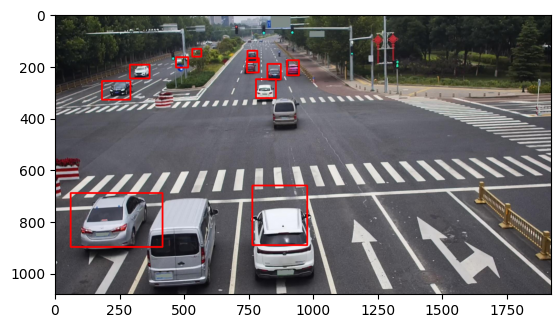

In [ ]:
img_bboxes = copy.deepcopy(img)
for bbox in data_sample.gt_instances.bboxes:
    bbox = np.expand_dims(bbox, axis=0)
    img_bboxes = plot_bboxes(img_bboxes, bbox)

img_bboxes = torch.Tensor(img_bboxes).to(torch.uint8)[:, :, [2, 1, 0]]
plt.imshow(img_bboxes)

## 3D bboxes

In [ ]:
corners_full = data_sample.gt_instances_3d.bboxes_3d.corners.T.numpy()

corners_full = np.concatenate([corners_full, np.ones((1, 8, corners_full.shape[2]))], axis=0)
corners_full = corners_full.reshape(4, -1)
# corners_full = np.dot(cam2img, corners_full)
corners_full = np.dot(lidar2img, corners_full)
corners_full = corners_full.reshape(4, 8, -1)
corners_full = corners_full / corners_full[2, :, :]
corners_full.shape

(4, 8, 11)

In [ ]:
corners_full[:, :, 0]

array([[ 5.06751220e+03,  4.60473440e+03,  5.28182905e+03,
         5.83617418e+03,  8.25711716e+03,  6.83767301e+03,
         7.82833454e+03,  9.44750661e+03],
       [ 5.63774888e+03,  6.61930727e+03,  6.45620581e+03,
         5.47360364e+03,  9.81845021e+03,  1.04851255e+04,
         1.01013482e+04,  9.36215393e+03],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00],
       [-2.42961134e-01, -2.10265359e-01, -2.05856284e-01,
        -2.37093381e-01, -4.25768074e-01, -3.34592861e-01,
        -3.23564937e-01, -4.08070103e-01]])

In [ ]:
corners_full[:, :, 0]

array([[ 5.06751220e+03,  4.60473440e+03,  5.28182905e+03,
         5.83617418e+03,  8.25711716e+03,  6.83767301e+03,
         7.82833454e+03,  9.44750661e+03],
       [ 5.63774888e+03,  6.61930727e+03,  6.45620581e+03,
         5.47360364e+03,  9.81845021e+03,  1.04851255e+04,
         1.01013482e+04,  9.36215393e+03],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00],
       [-2.42961134e-01, -2.10265359e-01, -2.05856284e-01,
        -2.37093381e-01, -4.25768074e-01, -3.34592861e-01,
        -3.23564937e-01, -4.08070103e-01]])

In [ ]:
lidar2cam

array([[-0.06380332, -0.99109149, -0.04429948, -5.7791444 ],
       [-0.21028734,  0.04399769, -0.79876929,  6.03761576],
       [ 0.97575115, -0.06031493, -0.17158543,  1.0636424 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

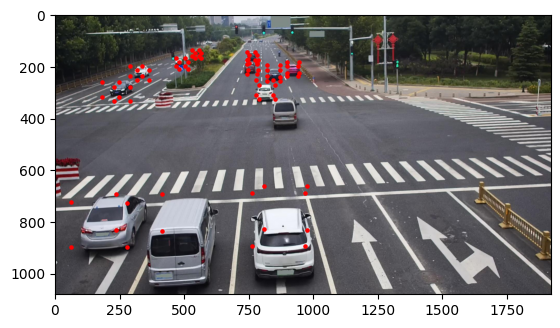

In [ ]:
lidar2img = data_sample.lidar2img
cam2img = np.array(data_sample.cam2img)
lidar2cam = data_sample.lidar2cam

corners = data_sample.gt_instances_3d.bboxes_3d.corners.T.numpy()
corners = np.concatenate([corners, np.ones((1, 8, corners_full.shape[2]))], axis=0)
corners = corners.reshape(4, -1)
img_corners = np.dot(cam2img, corners)
# img_corners = np.dot(lidar2img, corners)
img_corners = img_corners.reshape(4, 8, -1)
img_corners = img_corners / img_corners[2, :]

plt.imshow(img_plot)
# Print dots in image
for i in range(img_corners.shape[2]):
    plt.scatter(img_corners[0, :, i], img_corners[1, :, i], c='r', s=5)
# plt.scatter(img_corners[0], img_corners[1], c='r', s=10)

# Linear algebra

[0. 0.]
[ 0.70710678 -0.70710678]
[0.70710678 0.70710678]


(-0.8424621202458746,
 2.1353553390593274,
 -0.9192388155425117,
 3.747665940288702)

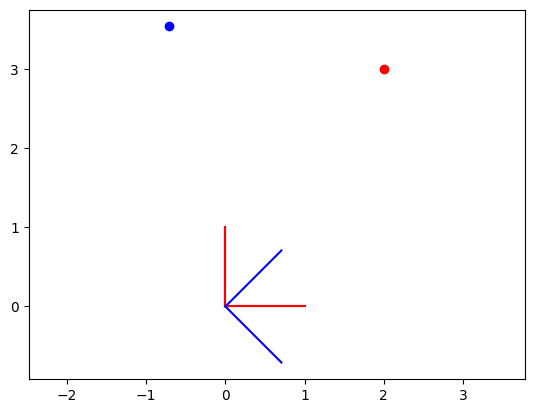

In [70]:
# a is a 2D point in a coordinate system
a = (2, 3)

# The coordinate system is rotated alpha degrees
alpha = np.pi/4
R = np.array([[np.cos(alpha), -np.sin(alpha)],
              [np.sin(alpha), np.cos(alpha)]])

# The coordinate system is translated by t
t = (1, 1)
t = (0, 0)

# The point in the new coordinate system is
b = np.dot(R, a) + t

# Plot a representation of the original and new coordinate system
plt.plot(a[0], a[1], 'ro')
plt.plot(b[0], b[1], 'bo')
plt.plot([0, 1], [0, 0], 'k')
plt.plot([0, 0], [0, 1], 'k')

# Get the inverse of R
R_inv = np.linalg.inv(R)
R_inv

p1 = (0, 0)
p2 = (1, 0)
p3 = (0, 1)

p1_new = np.dot(R_inv, p1)
p2_new = np.dot(R_inv, p2)
p3_new = np.dot(R_inv, p3)

print(p1_new)
print(p2_new)
print(p3_new)

plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r')
plt.plot([p1[0], p3[0]], [p1[1], p3[1]], 'r')
plt.plot([p1_new[0], p2_new[0]], [p1_new[1], p2_new[1]], 'b')
plt.plot([p1_new[0], p3_new[0]], [p1_new[1], p3_new[1]], 'b')

# Set same aspect ratio
plt.axis('equal')


In [79]:
# Transformation matrix of a rotation around the y-axis of an angle alpha
alpha = np.pi/4
R = get_rotation_matrix(alpha, 'x')

# Get the homogeneous transformation matrix
T = np.eye(4)
T[:3, :3] = R
T

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.70710678,  0.        ],
       [ 0.        ,  0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [77]:
# Transformation matrix of a rotation around the y-axis of an angle alpha
alpha = -np.pi/4
R = get_rotation_matrix(alpha, 'x')

# Get the homogeneous transformation matrix
T = np.eye(4)
T[:3, :3] = R
T

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678,  0.70710678,  0.        ],
       [ 0.        , -0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [78]:
np.linalg.inv(T)

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.70710678,  0.        ],
       [ 0.        ,  0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [ ]:
# Transformation matrix of a rotation around the y-axis of an angle alpha
alpha = np.pi/4
R = get_rotation_matrix(alpha, 'y')

# Get the homogeneous transformation matrix
T = np.eye(4)
T[:3, :3] = R

# Add a translation
t = np.array([1, 2, 3])
T[:3, 3] = t
T

array([[ 0.70710678,  0.        ,  0.70710678,  1.        ],
       [ 0.        ,  1.        ,  0.        ,  2.        ],
       [-0.70710678,  0.        ,  0.70710678,  3.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [81]:
pitch = 60 
pitch = np.deg2rad(pitch)
R = get_rotation_matrix(pitch, 'x')
T = np.eye(4)
T[:3, :3] = R

np.dot(cam2img, T.T)

array([[ 2.18635969e+03, -8.38929986e+02,  4.84356453e+02,
         0.00000000e+00],
       [ 0.00000000e+00,  6.96385477e+02,  2.29088843e+03,
         0.00000000e+00],
       [ 0.00000000e+00, -8.66025404e-01,  5.00000000e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])